# Import packages

### Import python packages

In [1]:
import re,os
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from parameters import *
from redatuming import redatuming
from plot_training import plot_training
from plot_redatuming import plot_redatuming
from plot_save import plot_save
import symae_core as symae

# Generate dataset X

### Define $n_\varepsilon$ states

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 3 states')

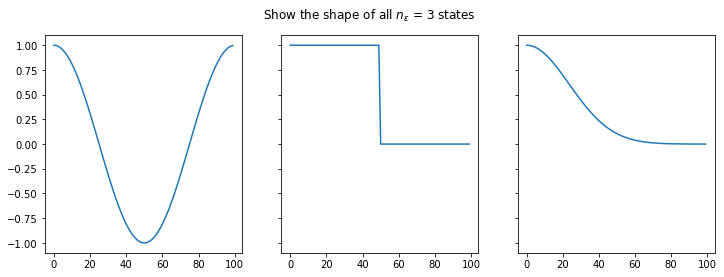

In [3]:
def g(n,x):
    if n==1:
        return int(x<0.5)
    elif n==2:
        return math.e**(-9*(x)**2)
    elif n==0:
        return math.cos(2*math.pi*x)
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

If replace==0, without replacement everywhere. Must $n_x*n_t <= n_\varepsilon*d$ and $n_t <= d$.  
If replace==1, X[i,:] have different nuisances, but each block in D can appear multiple times in X.  
If replace==2, with replacement everywhere.  
The default is replace=1.

In [4]:
MRA_training = MRA_generate(d,nt,N,sigma,ne,g,replace=0,continuous=False)
MRA_training.generate_default()
X = MRA_training.X

### Print the structure of dataset X

Plot how many times each block in D appears in X

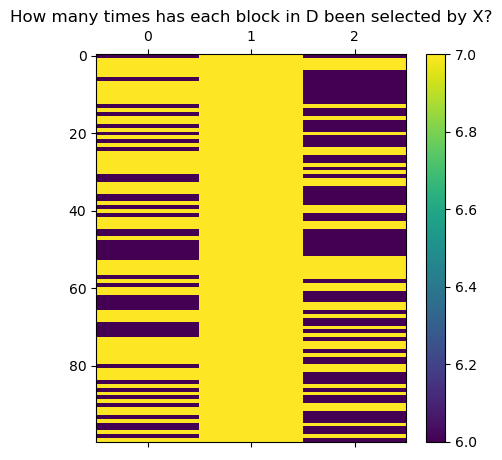

In [5]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Build SymAE

In [6]:
@tf.function
def bernoulli_mask(n, k):
    indices = tf.math.top_k(tf.random.uniform(shape=[n]), k, sorted=False).indices
    indices = tf.cast(indices, tf.int64)
    indices = tf.stack([indices, tf.zeros_like(indices)], axis=-1)
    out = tf.sparse.SparseTensor(indices=indices, values=tf.ones(indices.shape[0]), 
                                 dense_shape=[n,1])
    out = tf.sparse.reorder(out)
    return tf.sparse.to_dense(out)[:,0]

In [7]:
class My_Dropout(tf.keras.Model):
    '''WARNING: this layer highly rely on broadcasting'''
    def __init__(self, remain=1):
        super(My_Dropout, self).__init__(name='')
        self.remain = remain
    def call(self, x, training=False):
        #self.remain = tf.math.count_nonzero(tf.random.uniform([q])>0.5)
        if training==True:
            mask = bernoulli_mask(x.shape[-1], self.remain)
        elif training==False:
            mask = tf.ones_like(x)
        #tf.print(self.remain)
        z = x*mask
        return z
    
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=1.0, remain=2):
        super(LatentCat, self).__init__(name='')
        self.drop = tfkl.Dropout(alpha)
        self.my_drop = My_Dropout(remain)
    def call(self, zsym, znuisance,training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [8]:
class SymAE(tf.keras.Model):
    def __init__(self,N=1000,nt=20,d=100,p=8,q=22,kernel_size=5,
                 filters=64,dropout_rate=0.65,remain=2): 
        super(SymAE, self).__init__()
        
        # Build symmetric encoder
        sym_encoder=symae.SymmetricEncoder1D(kernel_size,filters,
                                             [2,2,2,2],[2,2,2,2],p)
        sym_encoder._name='sym_encoder'
        self.sym_encoder=sym_encoder
 
        # Build nuisance encoder
        nui_encoder=symae.NuisanceEncoder1D(kernel_size,filters,
                                            [2,2,2],[2,2,2,2],q)
        nui_encoder._name='nui_encoder'
        self.nui_encoder=nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        distzsym._name = 'dist'
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = symae.Mixer1D(kernel_size,filters,10,d)
        mixer._name = 'mixer'
        self.mixer = mixer
        
        # Build latentcat
        latentcat = LatentCat(alpha=dropout_rate, remain=remain)
        latentcat._name = 'latentcat'
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, x):
        sym_code = self.sym_encoder(x)
        nui_code = self.nui_encoder(x)
        z = self.latentcat(sym_code, nui_code)
        dist = self.distzsym(z)
        out = self.mixer(dist)
        return out

In [9]:
model = SymAE(N, nt, d, p, q, 5, 64, 0.5)
#model.load_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
clear_output()

In [10]:
model.latentcat.drop.rate = 0.5
#model.latentcat.my_drop.remain = 10

### Select the optimizer

In [11]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
SGD = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.0,nesterov=False)
model.compile(loss='mse',optimizer=Adam)

### Train the NeuralNet

In [12]:
MRA_validation = MRA_generate(d,nt,10,sigma,ne,g,replace=0,continuous=False)
MRA_validation.generate_default()
mse = tf.keras.losses.MeanSquaredError()
X_val = MRA_validation.X

In [ ]:
M = 1000 # How many epochs
epochs = range(M)
losses = [np.nan]*M
validations = [np.nan]*M
X = MRA_training.X
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        losses[epoch] = logs["loss"]
        #validations[epoch] = mse(X_val, model(X_val)[:,:,:,0])
        #print("Epoch {:d}, loss {:f}, val {:f}.".format(epoch, logs["loss"], validations[epoch]))
        print("Epoch {:d}, loss {:f}.".format(epoch, logs["loss"]))
        clear_output(wait = True)
history = model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

Epoch 429, loss 0.022020.


### Plot loss-epoch graph

In [ ]:
plt.plot(epochs,losses)
#plt.plot(epochs,validations)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Save weights

In [ ]:
model.save_weights('./checkpoint/'+'p=%d,q=%d,ne=%d'%(p,q,ne))
print("weights saved")

### Visualize the training result

In [ ]:
def find(state,nuisance):
    MRA_data = MRA_generate(d,nt,1,sigma,ne,g,replace=1)
    for i in range(1000):
        MRA_data.generate_default()
        if MRA_data.states[0] != state:
            continue
        for j in range(nt):
            if MRA_data.shifts[0][j] == nuisance:
                return MRA_data, j
test_X = find(2,0)[0].X
fig = plot_training(model,test_X)

# Redatuming

### Choose which 2 states and shifts you want to redatum 

In [ ]:
MRA1, t1 = find(2,0)
MRA2, t2 = find(1,0)

### Redatuming and the visualize it

In [ ]:
redatum = redatuming(model,MRA1,MRA2,t1,t2)
MSE_C1_N2, MSE_C2_N1 = redatum.MSE()
fig = plot_redatuming(redatum)
clear_output()
print('The MSE of C1N2 is: %f'%MSE_C1_N2)
print('The MSE of C2N1 is:%f'%MSE_C2_N1)

### List many redatuming

In [ ]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, nt, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,:]
def enc(state, shift):
    MRA1, t1 = find(state,shift)
    tem = model.encoder(MRA1.X)
    return tem[0][0:p+q]

In [ ]:
state_source = 2
nuisance_source = 1
fig, axs = plt.subplots(1, d, sharex=True, sharey=True, figsize=(4*d,4), dpi=40)
for i in trange(d):
    coherent_code = enc(state_source, 0)[0: p]
    nuisance_code = enc(nuisance_source, i)[p: p+q]
    latent_code = np.concatenate([coherent_code, nuisance_code], axis=0)
    axs[i].plot(range(d), dec(latent_code))
    axs[i].set_title('%d'%i)
plt.suptitle('$\hat{X}_{s=%d \mapsto s=%d}$'%(nuisance_source, state_source), fontsize=50)
plt.subplots_adjust(top=0.6)
plt.show()
#fig.savefig('./plots/%dto%d'%(nuisance_source, state_source))

# New

In [ ]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()

In [ ]:
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]

In [ ]:
C_code = model.sym_encoder.predict(MRA_test.X,verbose=0)
C_reshaped = C_code.reshape(-1,p)

### latent nuisance space

In [ ]:
fig, axs = plt.subplots(1, q, sharex=True, sharey=True, figsize=(q*8,5))
for i in trange(q):
    for s in range(ne):
        axs[i].scatter(N_shifts[s_sub[s]],N_reshaped[:,i][s_sub[s]],color='C%d'%s,label=s)
        axs[i].set_title('%d-th dim'%i)
        axs[i].set_xlabel('real shift')
        axs[i].set_ylabel('%d-th latent'%i)
        axs[i].legend()
        axs[i].grid()
fig.suptitle('latent nuisance space')
fig.show()

### latent coherent space

In [ ]:
axs=[0]
fig, axs[0] = plt.subplots(1, p, sharex=True, sharey=True, figsize=(p*5,4))
for i in trange(p):
    for s in range(ne):
        axs[i].scatter(C_reshaped[:,i][MRA_test.states==s],np.zeros(sum(MRA_test.states==s)),color='C%d'%s)
        axs[i].set_xlabel('%d-th latent'%i)
fig.suptitle('latent coherent space')
fig.tight_layout()
fig.show()